# Bayesian Conditional Moment Restriction

We know that
\begin{equation}
\mathbb{E} \left[(Y-f(X)) h(Z)\right] = 0\qquad \forall h
\end{equation}

Given observed data $\{\mathbf{X}, \mathbf{Y}, \mathbf{Z}\} = \{(x_i, y_i, z_i)\}_{i=1}^N$, we want to learn the function $f$ such that the above statement is satisfied.  
Denote $\mathbf{h} = h(\mathbf{Z})$ and similarly, $\mathbf{f} = f(\mathbf{Z})$.  
Define $b = \sum_{i=1}^N (f(x_i) - y_i) h(z_i)\ =\ \mathbf{h}^\intercal\mathbf{f} - \mathbf{h}^\intercal\mathbf{Y}$ the empirical expectation above (up to a factor $1/N$ which can be ignored).

In [1]:
import numpy as np
import scipy.linalg as slinalg
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import sys
from util_original import get_median_inter_mnist, Kernel, load_data, ROOT_PATH, jitchol, _sqdist
# sys.path.insert(0, "/home/alex/Projects/MMRIV/")

In [2]:
# Some fake data
class DataGen():
    def __init__(self, slope_1=3.0, slope_2=0.15,
                 intercept_1=0.0, intercept_2=0.0):
        self.slope_1 = slope_1
        self.slope_2 = slope_2
        self.intercept_1 = intercept_1
        self.intercept_2 = intercept_2

    def generate_data(self, num_data, **kwargs):

        epsilon = 4.e-1*np.random.normal(size=(num_data,1)) # 4e-1
        eta = 1.e-1*np.random.normal(size=(num_data,1))
        z = 2*np.random.normal(size=(num_data, 1))

        x = -z + epsilon
        g = self.g_fun(x)
        y = g + epsilon + eta
        
        return x, y, z, g

    def g_fun(self, x):
        return (x+np.abs(x)) > 0 # np.sin(x)

In [3]:
np.random.seed(0)

# hls = DataGen()
# X, Y, Z, G= hls.generate_data(400)
# print(X.shape, Y.shape, Z.shape)
sname = 'step'
datasize=200
train, dev, test = load_data(ROOT_PATH + '/data/zoo/{}_{}.npz'.format(sname, datasize))
X = np.vstack((train.x, dev.x))
Y = np.vstack((train.y, dev.y))
Z = np.vstack((train.z, dev.z))
Z = Z[:,[0]]
test_X = test.x
test_G = test.g

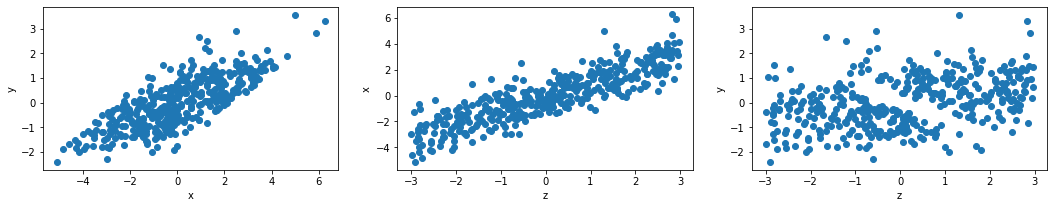

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(18,3))

ax[0].scatter(X, Y)
ax[1].scatter(Z, X)
ax[2].scatter(Z, Y)

xlabel = ['x', 'z', 'z']
ylabel = ['y', 'x', 'y']

for i in range(3):
    ax[i].set_xlabel(xlabel[i])
    ax[i].set_ylabel(ylabel[i])

In [5]:
# skip this: this is to double check the data are generated correctly

# Z = np.random.uniform(-3,3,size=(400,1))
# e = np.random.normal(0,1,size=(400,1))
# gamma = np.random.normal(0,0.1,size=(400,1))
# delta = np.random.normal(0,0.1,size=(400,1))
# X = Z+e+gamma
# G = (X+np.abs(X)) > 0
# Y = G+e+delta
# plt.scatter(X,Y)
# plt.show()

## 1. Bayesian Model

We set up the following probabilistic model:
- **prior:** $f\sim \mathcal{GP} (m, k)$
- **likelihood:** $ \mathbf{h} \mid \mathbf{f} \sim \delta (\mathbf{h}^\intercal\mathbf{f} - \mathbf{h}^\intercal\mathbf{Y})$

Since we are dealing with linear projections of $f$ in the likelihood, the posterior is available in closed form :-)

Given one "observation" (choice) of $\mathbf{h}$ we find the following posterior on $f$:
$$ 
f \mid \mathbf{h} \sim
\mathcal{GP} \left(m_\cdot + k_{\cdot\mathbf{X}} \mathbf{h} (\mathbf{h}^\intercal \mathbf{K} \mathbf{h})^{-1} \mathbf{h}^\intercal (\mathbf{m} - \mathbf{Y}),
k_{\cdot\cdot} - k_{\cdot\mathbf{X}} \mathbf{h} (\mathbf{h}^\intercal \mathbf{K} \mathbf{h})^{-1} \mathbf{h}^\intercal k_{\mathbf{X}\cdot}
\right)
$$

with $\mathbf{K} = k_{\mathbf{X} \mathbf{X}}$, $\mathbf{m} = m(\mathbf{X})$

In [6]:
class GP_model:
    def __init__(self, data, kernel):
        self.data = data
        self.kernel = kernel
        self.K = self.kernel.k(self.data.X, self.data.X)
    
    def predict(self, x, full_cov=False):
        if self.data.H is None:
            return self._prior(x, full_cov=full_cov)
        kXx = self.kernel.k(self.data.X, x)
        mean = kXx.T @ self._mid_matrix() @ self.data.Y
        cov = self.kernel.k(x,x) - kXx.T @ self._mid_matrix() @ kXx
        if full_cov:
            return mean, cov
        else:
            return mean, np.diag(cov)
        
    def _mid_matrix(self):
        HKH = self.data.H.T @ (self.K @ self.data.H)
        L_HKH, low = slinalg.cho_factor(HKH + 1.e-6 * np.eye(self.data.H.shape[-1]))
        return self.data.H @ slinalg.cho_solve((L_HKH, low), self.data.H.T)
    
    def _prior(self, x, full_cov):
        cov = self.kernel.k(x,x) if full_cov else np.diag(self.kernel.k(x,x))
        return np.zeros((x.shape[0], 1)), cov
      
        
class SE_kernel:
    def __init__(self, lengthscale, variance):
        self.l = lengthscale
        self.v = variance
        
    def k(self, x1, x2):
        arg = ((x1[:, None, :] - x2[None, :, :])**2).sum(axis=-1)/(2.*self.l**2)
        return self.v * np.exp(-arg)
    

class Linear_kernel:
    def __init__(self, center, variance1,variance2):
        self.c = center
        self.v1 = variance1
        self.v2 = variance2
        
    def k(self, x1, x2):
        arg = (x1- self.c)@(x2 - self.c).T
        return self.v1 * arg +self.v2
    

class Data:
    """
    Class to keep track of data
    """
    def __init__(self, X, Y, Z):
        self.X = X
        self.Y = Y
        self.Z = Z # actually we don't need and care about Z for the Bayesian model at the moment
        self.num_data = self.X.shape[0]
        self.H = None
        
    def add_h_obs(self, h):
        """
        Add an observation of h
        """
        if len(h.shape) != 2:
            h = h.reshape(self.num_data, -1)
        if self.H is None:
            self.H = h
        else:
            self.H = np.hstack([self.H, h])

In [7]:
a = np.array([[1],[2]])
a[:,None,:]

array([[[1]],

       [[2]]])

### Let's get an idea of the effect of conditioning on $\mathbf{h}$

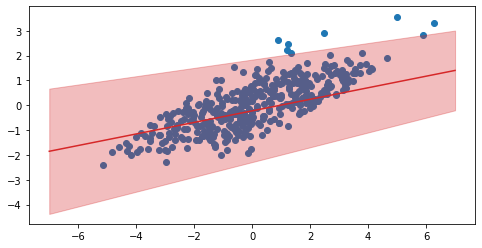

In [8]:
data = Data(X, Y, Z)

h0 = Z
data.add_h_obs(h0)

k = Linear_kernel(1.,1.,1.)# SE_kernel(1., 1.)
gp = GP_model(data, k)

x_plot = np.linspace(-7, 7, 50).reshape(-1,1)
f_mean, f_var = gp.predict(x_plot)

fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.scatter(X, Y)
ax.plot(x_plot, f_mean, c='C3')
ax.fill_between(x_plot[:,0], f_mean[:,0] - 2.*np.sqrt(f_var), f_mean[:,0] + 2.*np.sqrt(f_var), color='C3', alpha=0.3)

### 2. Active Learning Strategy

We sequentially wish to select values of $\mathbf{h}$ such that the unconditional moment relation reduces the variance of $f$ at locations $\mathbf{X}$.
As utility function, let us consider the sum over the variance of $\mathbf{f}$, i.e.,
\begin{align}
u(\mathbf{h}) 
&= \operatorname{tr} \left(\mathbf{K} - \mathbf{K} \mathbf{h} (\mathbf{h}^\intercal \mathbf{K} \mathbf{h})^{-1} \mathbf{h}^\intercal \mathbf{K} \right)\\
&= \operatorname{tr} \left(\mathbf{K} \right) - \frac{\mathbf{h}^\intercal \mathbf{K} \mathbf{K} \mathbf{h}}{\mathbf{h}^\intercal \mathbf{K} \mathbf{h}}
\end{align}

Then we want to find
$$
\mathbf{h}_\ast = \operatorname{argmin}_{\mathbf{h} \in \mathbb{R}^N} u(\mathbf{h}).
$$
A regularizer can be included in the optimization.  

Let us collect $M$ instances of $\mathbf{h}$ in $\mathbf{H} \in \mathbb{R}^{N\times M}$. Given previous choices of $\mathbf{h}$, the utility becomes

$$
u(\mathbf{h} \mid \mathbf{H})
= \operatorname{tr} \left(\mathbf{K} - \mathbf{D}\right) 
- \frac{\mathbf{h}^\intercal(\mathbf{K} - \mathbf{D})(\mathbf{K} - \mathbf{D})\mathbf{h}}{\mathbf{h}^\intercal(\mathbf{K} - \mathbf{D}) \mathbf{h}}
$$

with $\mathbf{D} = \mathbf{K} \mathbf{H} (\mathbf{H}^\intercal \mathbf{K} \mathbf{H})^{-1} \mathbf{H}^\intercal \mathbf{K}$

In [9]:
class Utility:
    def __init__(self, gp_model):
        self.gp = gp_model
    
    def evaluate(self, h, grad=True):
        KminD = self._KminD()
        hAh = np.einsum('i,ij,j->', h, KminD, h)
        hAAh = np.einsum('i,ij,jk, k->', h, KminD, KminD, h)
        
        if grad:
            Ah = np.einsum('ij,j->i', KminD, h)
            AAh = np.einsum('ij,jk,k->i', KminD, KminD, h)
            return np.trace(KminD) - hAAh / hAh, hAAh/hAh**2 * Ah - AAh / hAh 
        
        return np.trace(KminD) - hAAh / hAh
    
    def grad(self, h):
        _, g = self.evaluate(h, grad=True)
        return g
    
    def hess(self, h):
        pass
        
    def _KminD(self):
        if self.gp.data.H is None:
            return self.gp.K
        H_HKHinv_H = self.gp._mid_matrix()
        return self.gp.K - self.gp.K @ H_HKHinv_H @ self.gp.K

## 3. Run the active learning loop


In [10]:
data = Data(X, Y, Z)

k = Linear_kernel(1.,1.,1.)# SE_kernel(1., 1.)
gp = GP_model(data, k)

# Check: predict uses the prior since H is None
x_plot = np.linspace(-7, 7, 50).reshape(-1,1)
f_mean, f_var = gp.predict(x_plot)

# define utility
u = Utility(gp)

[0.30572824]
[0.28830043]
[0.28830043]
[0.28830043]
[0.28830043]
[0.28830043]
[0.28830043]
[0.28830043]
[0.28830043]
[0.28830043]


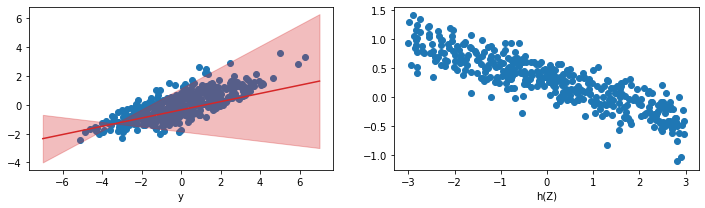

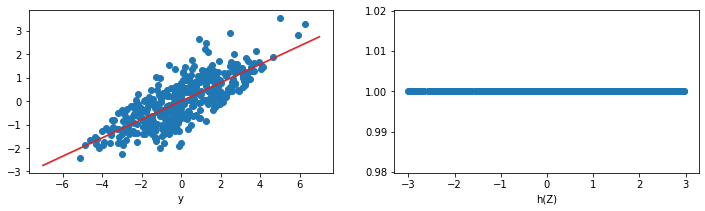

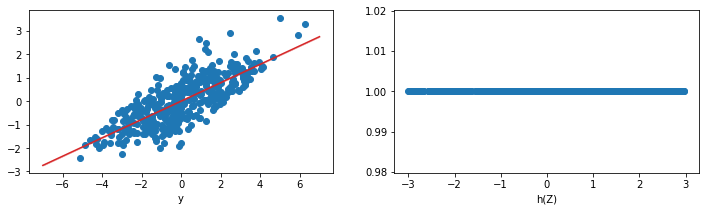

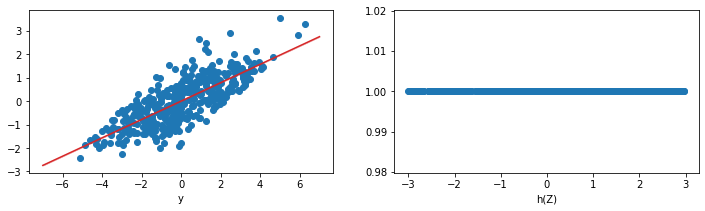

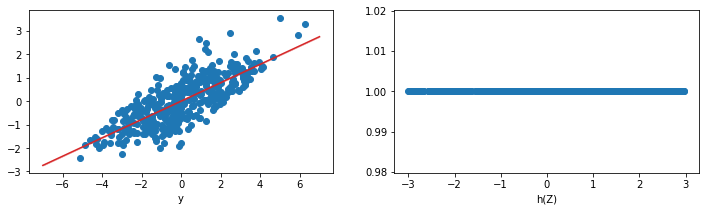

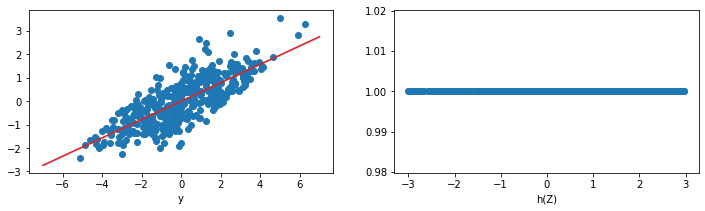

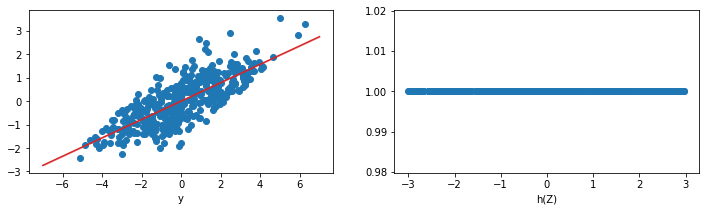

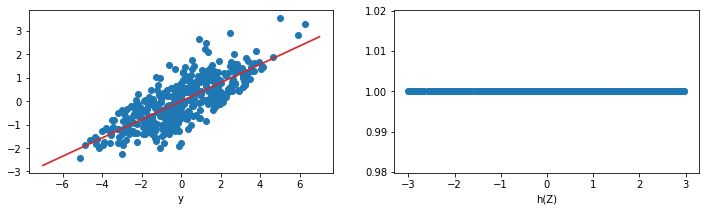

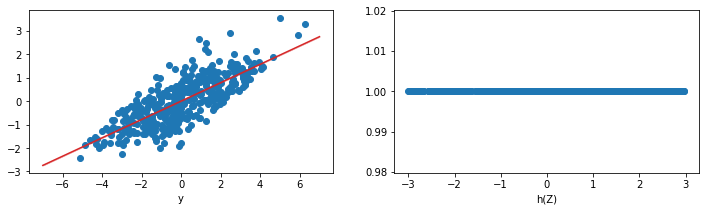

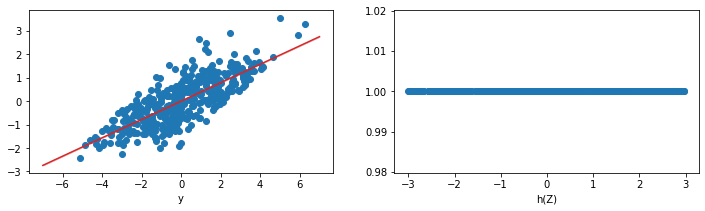

In [11]:
# run active learning loop

n_loop = 10

for i in range(n_loop):
    min_u = minimize(u.evaluate, np.ones_like(h0), jac=True)
    h_new = min_u.x
    data.add_h_obs(h_new)
    

    # plot intermediate GP posterior and selections of h
    f_mean, f_var = gp.predict(x_plot)
    
    fig, ax = plt.subplots(1, 2, figsize=(12,3))
    ax[0].scatter(X, Y)
    ax[0].plot(x_plot, f_mean, c='C3')
    
    f_mean_X, _ = gp.predict(test.x)
    print(np.mean((f_mean_X - test.g)**2,axis=0))
    
    ax[0].fill_between(x_plot[:,0], f_mean[:,0] - 2.*np.sqrt(f_var), f_mean[:,0] + 2.*np.sqrt(f_var), color='C3', alpha=0.3)
    ax[0].set_xlabel('x')
    ax[0].set_xlabel('y')
    
    ax[1].scatter(Z, h_new)
    ax[1].set_xlabel('Z')
    ax[1].set_xlabel('h(Z)')


[0.28830043]
[0.28830043]
[0.28830043]
[0.28830043]
[0.28830043]
[0.28830043]
[0.28830043]
[0.28830043]
[0.28830043]
[0.28830043]


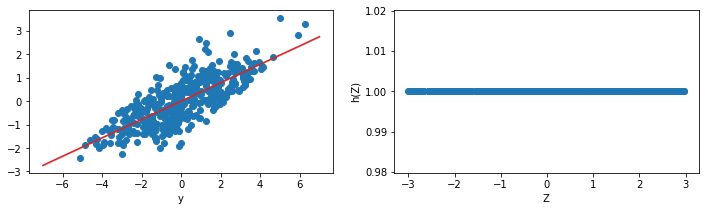

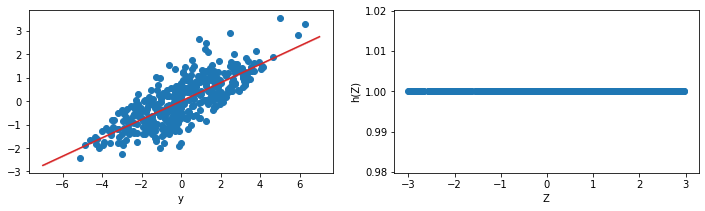

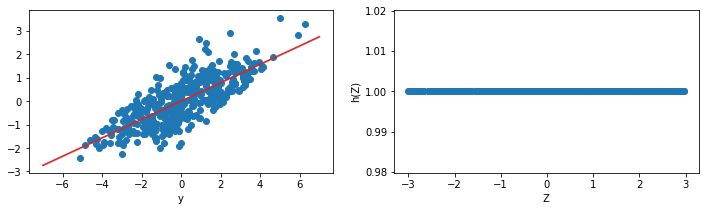

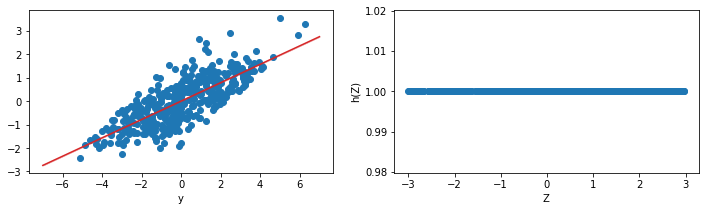

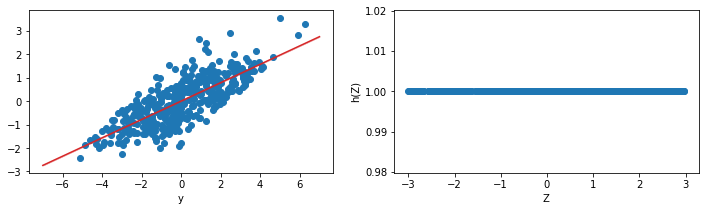

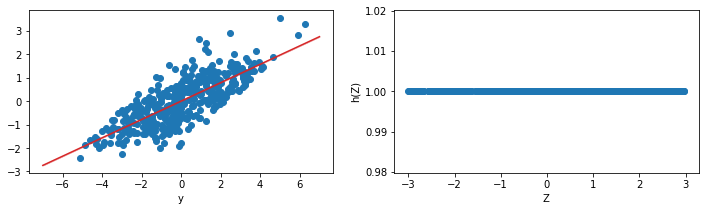

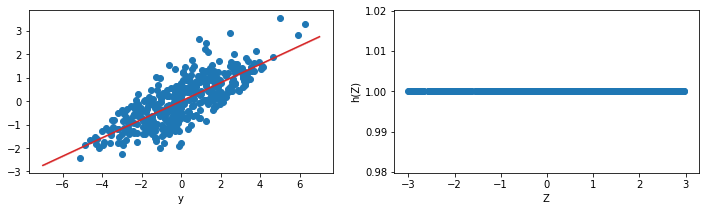

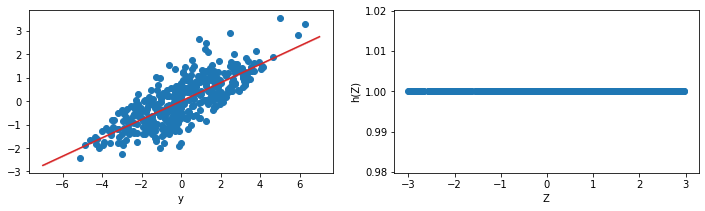

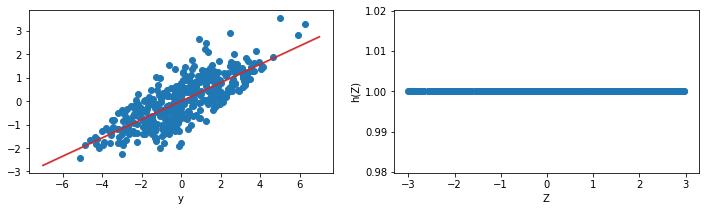

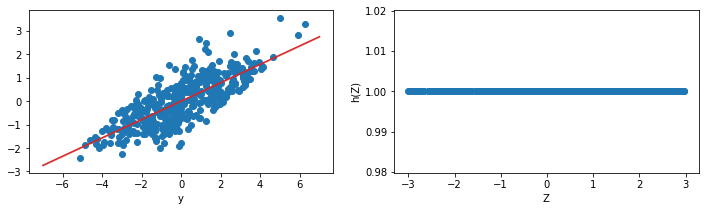

In [12]:
# run active learning loop

n_loop = 10

for i in range(n_loop):
    min_u = minimize(u.evaluate, np.ones_like(h0), jac=True)
    h_new = min_u.x
    data.add_h_obs(h_new)
    

    # plot intermediate GP posterior and selections of h
    f_mean, f_var = gp.predict(x_plot)
    
    fig, ax = plt.subplots(1, 2, figsize=(12,3))
    ax[0].scatter(X, Y)
    ax[0].plot(x_plot, f_mean, c='C3')
    
    f_mean_X, _ = gp.predict(test.x)
    print(np.mean((f_mean_X - test.g)**2,axis=0))
    
    ax[0].fill_between(x_plot[:,0], f_mean[:,0] - 2.*np.sqrt(f_var), f_mean[:,0] + 2.*np.sqrt(f_var), color='C3', alpha=0.3)
    ax[0].set_xlabel('x')
    ax[0].set_xlabel('y')
    
    ax[1].scatter(Z, h_new)
    ax[1].set_xlabel('Z')
    ax[1].set_ylabel('h(Z)')
